In [17]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.style.use('seaborn-darkgrid')

DATA_PATH = Path("__file__").absolute().parent / 'data'
COLORS = [
    '#FFFF66', '#FF945A', '#319EA1', '#D14A89',
    '#405E00', '#A0B7DA', '#FF6501', '#0082B6',
    '#F4C541', '#E79798', '#CBBDA2', '#FDC975',
         ]

TITLES_IMPORTANT = [
    'Temperature',
    'Pressure',
    'Wind Direction',
    'Wind Speed',
    'Coluds Hight',
]

FEATURE_KEYS_IMPORTANT = [
    "temperature",
    "pressure",
    "wind_dir",
    "wind_speed",
    "coluds_hight",
]

SIDES = {
    0: "None",
    1: "South",
    2: "West",
    3: "South-Southwest",
    4: "North-West",
    5: "North",
    6: "South-Southeast",
    7: "West-Northwest",
    8: "South-West",
    9: "North-Northwest",
    10: "West-Southwest",
    11: "South-East",
    12: "East-Southeast",
    13: "East",
    14: "North-Northeast",
    15: "North-East",
    15: "East-Northeast",
    17: "No Wind",
}

WEATHER = [
    "rain",
    "snow",
    "fog",
    "hail",
    "drizzle",
    "precipitation",
    "ice_pellets",
    "other",
]

# Reading data and dropping usles or almost empty cols
df = pd.read_csv(DATA_PATH / 'data_cleaned.csv')

# df.rename(columns={"date": "year", "date.1": "month", "date.2": "day"}, inplace=True)
# df['date'] = pd.to_datetime(df[['day','month','year']])
df.index = df['date']
df.drop(['date'], axis=1, inplace=True)
# df.drop(['year', 'month', 'day', 'date'], axis=1, inplace=True)

df_important = df[['temperature', 'pressure', 'wind_dir', 'wind_speed', 'coluds_hight']]
df_weather = df[['rain', 'snow', 'fog', 'hail', 'drizzle', 'precipitation', 'ice_pellets', 'other']]

%matplotlib inline

In [18]:
df_important

,temperature,pressure,wind_dir,wind_speed,coluds_hight
date,,,,,
10/07/2013 17:00,13.6,771.7,6,3.0,8
10/07/2013 18:00,11.1,770.8,13,1.0,6
10/07/2013 19:00,12.9,771.5,13,3.0,8
10/07/2013 20:00,11.9,771.7,13,2.0,8
10/07/2013 21:00,10.0,771.3,14,1.0,1
...,...,...,...,...,...
25/01/2021 18:00,2.7,755.8,7,4.0,6
25/01/2021 19:00,2.0,756.1,7,2.0,6
25/01/2021 20:00,1.9,756.5,7,3.0,6


In [19]:
df = df_important

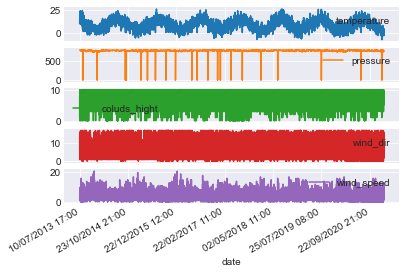

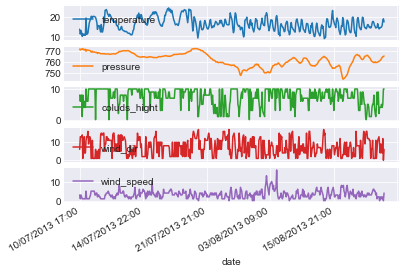

In [20]:
plot_cols = ['temperature', 'pressure', 'coluds_hight', 'wind_dir', 'wind_speed']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
_ = plot_features.plot(subplots=True)

In [21]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,62996.0,8.911694,4.967972,-7.9,5.2,8.9,12.6,26.4
pressure,62996.0,757.289029,23.154269,0.0,751.7,759.0,764.7,785.9
wind_dir,62996.0,6.276002,4.406044,0.0,2.0,6.0,9.0,17.0
wind_speed,62996.0,4.483793,2.746190,0.0,2.0,4.0,6.0,21.0
coluds_hight,62996.0,7.802368,2.309099,0.0,6.0,8.0,10.0,10.0


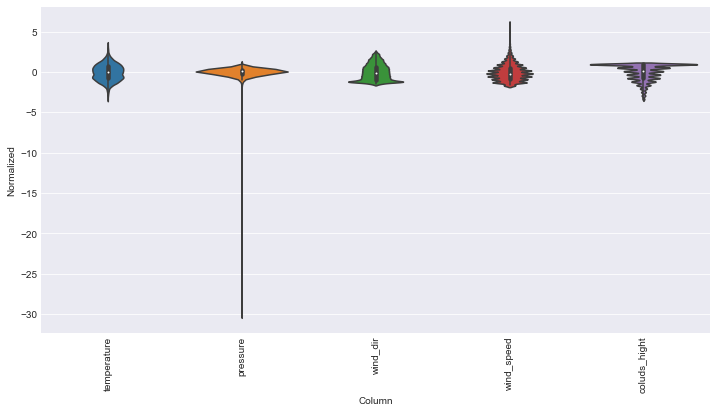

In [26]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [27]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [29]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['temperature'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['temperature']

In [31]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['temperature'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temperature']

In [32]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [33]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


In [34]:
w2.example = example_inputs, example_labels

In [37]:
def plot(self, model=None, plot_col='temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

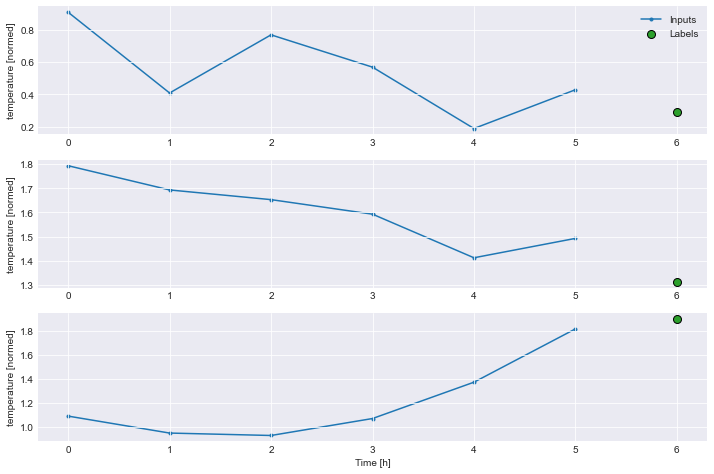

In [38]:
w2.plot()

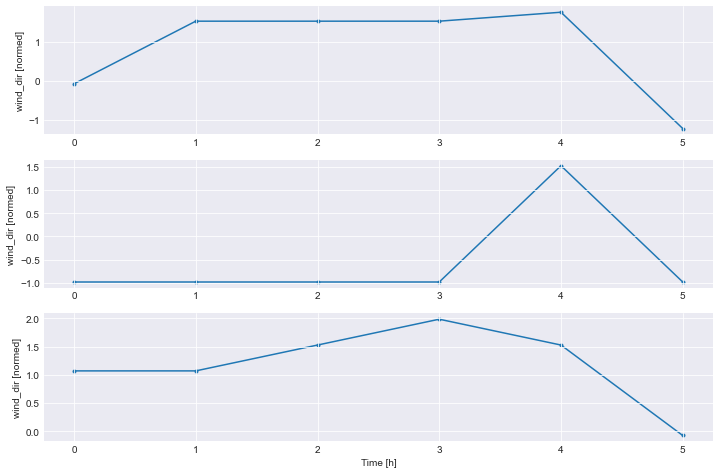

In [39]:
w2.plot(plot_col='wind_dir')

In [40]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [41]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [42]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [43]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [44]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temperature'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temperature']

In [45]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [46]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [48]:
baseline = Baseline(label_index=column_indices['temperature'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

394/394 [==============================] - 0s 1ms/step - loss: 0.0478 - mean_absolute_error: 0.1418


In [50]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temperature'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temperature']

In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


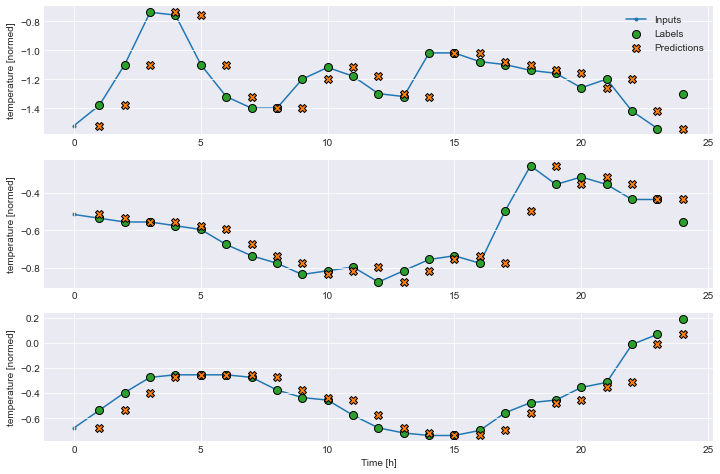

In [52]:
wide_window.plot(baseline)

In [53]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [54]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [55]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [56]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
1378/1378 [==============================] - 2s 2ms/step - loss: 0.8926 - mean_absolute_error: 0.4312 - val_loss: 0.1584 - val_mean_absolute_error: 0.2791
Epoch 2/10
1378/1378 [==============================] - 2s 1ms/step - loss: 0.3629 - mean_absolute_error: 0.2270 - val_loss: 0.0970 - val_mean_absolute_error: 0.2184
Epoch 3/10
1378/1378 [==============================] - 2s 1ms/step - loss: 0.1729 - mean_absolute_error: 0.1782 - val_loss: 0.0634 - val_mean_absolute_error: 0.1733
Epoch 4/10
1378/1378 [==============================] - 2s 1ms/step - loss: 0.0774 - mean_absolute_error: 0.1454 - val_loss: 0.0498 - val_mean_absolute_error: 0.1484
Epoch 5/10
1378/1378 [==============================] - 2s 1ms/step - loss: 0.0437 - mean_absolute_error: 0.1304 - val_loss: 0.0471 - val_mean_absolute_error: 0.1419
Epoch 6/10
1378/1378 [==============================] - 2s 2ms/step - loss: 0.0379 - mean_absolute_error: 0.1277 - val_loss: 0.0473 - val_mean_absolute_error: 0.1418
Epoc

In [57]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


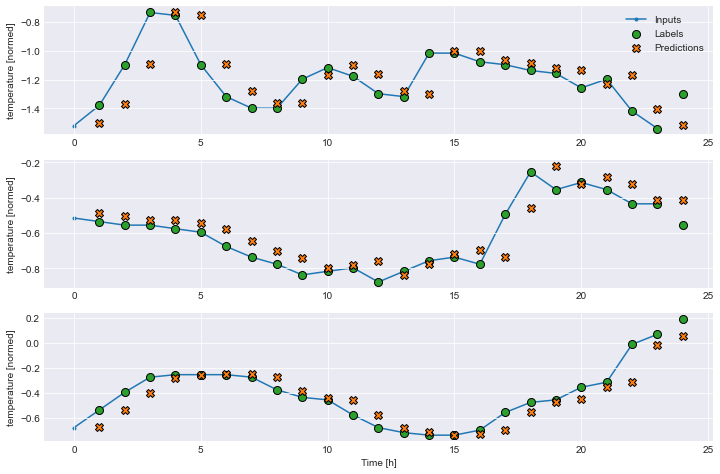

In [58]:
wide_window.plot(linear)

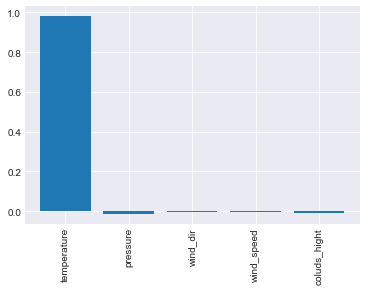

In [59]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [60]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
1378/1378 [==============================] - 2s 2ms/step - loss: 0.0541 - mean_absolute_error: 0.1470 - val_loss: 0.0487 - val_mean_absolute_error: 0.1461
Epoch 2/10
1378/1378 [==============================] - 2s 2ms/step - loss: 0.0409 - mean_absolute_error: 0.1331 - val_loss: 0.0484 - val_mean_absolute_error: 0.1462
Epoch 3/10
1378/1378 [==============================] - 3s 2ms/step - loss: 0.0397 - mean_absolute_error: 0.1322 - val_loss: 0.0494 - val_mean_absolute_error: 0.1466
Epoch 4/10
1378/1378 [==============================] - 2s 2ms/step - loss: 0.0394 - mean_absolute_error: 0.1322 - val_loss: 0.0475 - val_mean_absolute_error: 0.1450
Epoch 5/10
1378/1378 [==============================] - 3s 2ms/step - loss: 0.0389 - mean_absolute_error: 0.1312 - val_loss: 0.0488 - val_mean_absolute_error: 0.1448
Epoch 6/10
394/394 [==============================] - 1s 1ms/step - loss: 0.0479 - mean_absolute_error: 0.1448


In [62]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['temperature'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['temperature']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

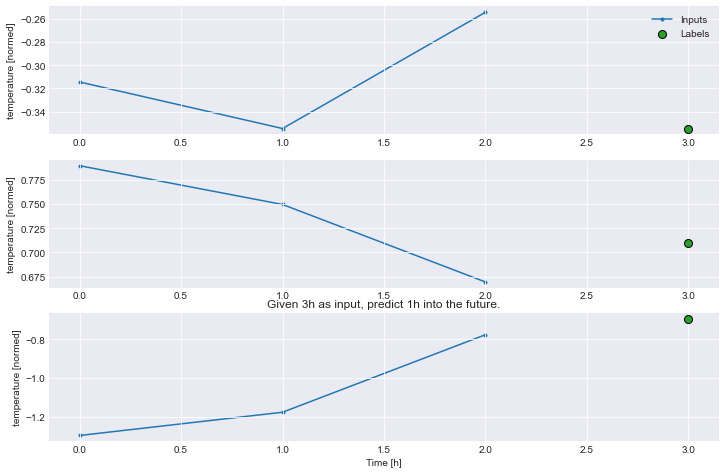

In [63]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [64]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [65]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 5)
Output shape: (32, 1, 1)
